# Lambda School Data Science - Generative Adversarial Networks

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [ ]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

In [132]:
from os import listdir
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers

In [105]:
# Interpret all emoji and put them into an array
all_emoji = []
for path in listdir('emoji/'):
    # Read in the file
    emojus = imageio.imread('emoji/' + path)
    # Remove the transparency dimension 
    emojus = np.delete(emojus, -1, 2)
    # Scale
    emojus = emojus/255
    # Resize
    emojus = emojus.reshape(2352,)
    # Add to list
    all_emoji.append(emojus)

# Turn list into numpy array
all_emoji = np.array(all_emoji)
all_emoji.shape

(861, 2352)

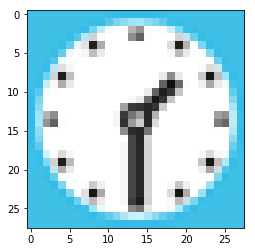

In [118]:
# The 861 images are preserved, with color!
plt.imshow(all_emoji[4].reshape(28,28,3));

In [119]:
np.random.seed(42)
random_dim = 200

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=2352,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(2352, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=25, dim=(5, 5),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 3)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest') #, cmap='gray_r'
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [123]:
batch_size=30
all_emoji[np.random.randint(0, all_emoji.shape[0], size=batch_size)].shape

(30, 2352)

In [128]:
def train(epochs=1, batch_size=30):

    # Split the training data into batches of size 128
    batch_count = all_emoji.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            # Get a random sampling of images from the training data
            image_batch = all_emoji[np.random.randint(0, all_emoji.shape[0],
                                                    size=batch_size)]
 
            # Generate fake emoji, equal in length to batch_size
            generated_images = generator.predict(noise)
            # Concatenate real and fake images
            X = np.concatenate([image_batch, generated_images])
            
            ## Mark real images with, fake ones with 0.9
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
 
            # Train discriminator on this dataset of real+fake
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train the whole GAN on noise, while turning its
            # discriminator off (so that only the generator updates its weights).
            # This is making the generator better at fooling the discriminator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

  0%|          | 0/28 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 28/28 [00:07<00:00,  6.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

--------------- Epoch 2 ---------------


  4%|▎         | 1/28 [00:00<00:04,  6.64it/s]

--------------- Epoch 3 ---------------


  4%|▎         | 1/28 [00:00<00:04,  5.79it/s]

--------------- Epoch 4 ---------------


  4%|▎         | 1/28 [00:00<00:04,  6.46it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/28 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  4%|▎         | 1/28 [00:00<00:04,  6.46it/s]

--------------- Epoch 7 ---------------


  4%|▎         | 1/28 [00:00<00:04,  6.51it/s]

--------------- Epoch 8 ---------------


  4%|▎         | 1/28 [00:00<00:04,  6.02it/s]

--------------- Epoch 9 ---------------


 36%|███▌      | 10/28 [00:01<00:02,  6.25it/s]


KeyboardInterrupt: 

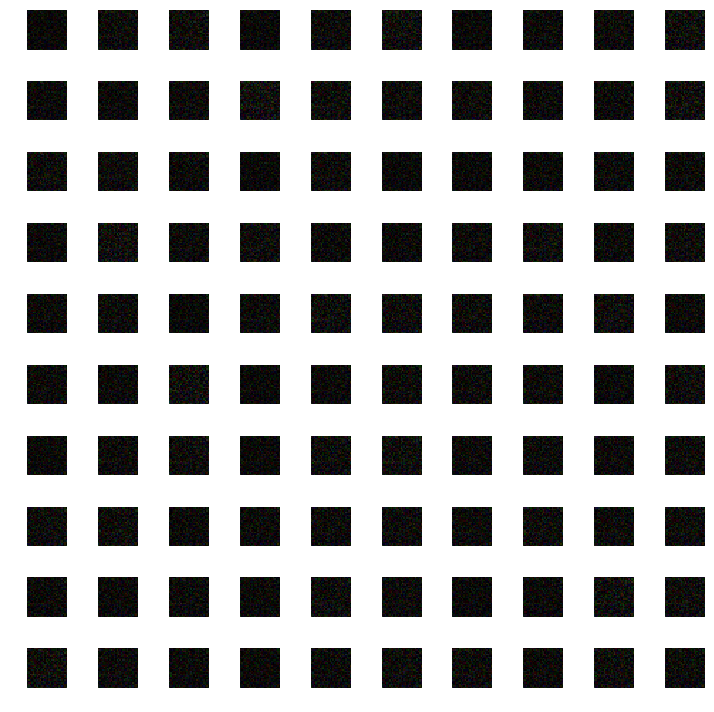

In [133]:
train(40, 30)

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji